In [1]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.nn import MSELoss
from src.spaces.sphere import Sphere
from src.spaces.grassmanian import Grassmanian
from src.spectral_kernel import EigenbasisSumKernel
from src.prior_approximation import RandomPhaseApproximation
from src.spectral_measure import MaternSpectralMeasure, SqExpSpectralMeasure
import matplotlib.pyplot as plt
import numpy as np
import gpytorch
import os
import sys
sys.setrecursionlimit(2000)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.autograd.set_detect_anomaly(True)
dtype = torch.float64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib widget

INFO: Using numpy backend


In [2]:

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):  # pylint: disable=arguments-differ
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [3]:
def train(model, train_x, train_y):
    training_iter = 900
    # Find optimal model hyperparameters
    model.train()
    model.likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters
    scheduler = StepLR(optimizer, step_size=300, gamma=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        #print(scheduler.get_lr())
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()
        if i % 100 == 99:
            try:
                lengthscale = model.covar_module.base_kernel.lengthscale.item()
                variance = model.covar_module.outputscale
            except:
                lengthscale = model.covar_module.kernel.measure.lengthscale.item()
                variance = model.covar_module.kernel.measure.variance.item()
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f variance: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                lengthscale,
                variance,
                model.likelihood.noise.item()
            ))

In [4]:
def sphere_lattice(r=1., nlats=301, nlons=301, center=None):
    if center is None:
        center = np.r_[0, 0, 0]
    phi, theta = np.mgrid[0:np.pi:nlats*1j, 0:2 * np.pi:nlons*1j]

    x = r * np.sin(phi) * np.cos(theta) + center[0]
    y = r * np.sin(phi) * np.sin(theta) + center[1]
    z = r * np.cos(phi) + center[2]

    return torch.tensor(x, device=device, dtype=dtype), \
           torch.tensor(y, device=device, dtype=dtype),\
           torch.tensor(z, device=device, dtype=dtype)

def plot_sphere(x, y, z, c):
    x_, y_, z_, c_ = x.detach().cpu(), y.detach().cpu(), z.detach().cpu(), c.detach().cpu()
    cmap = plt.get_cmap('plasma')
    ax=plt.subplot(111, projection='3d')
    surf = ax.plot_surface(x_, y_, z_,
                           cstride=1, rstride=1,
                           cmap=cmap,
                           facecolors=cmap(c_))
    plt.show()
    #ax.set_axis_off()

In [5]:
order = 10
sphere = Sphere(n=2, order=order)

In [6]:
lengthscale, nu = 0.1, 5.0 + sphere.dim
measure = SqExpSpectralMeasure(sphere.dim, lengthscale)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

In [7]:
sphere_kernel = EigenbasisSumKernel(measure=measure, manifold=sphere)
sphere_sampler = RandomPhaseApproximation(kernel=sphere_kernel, phase_order=10**2)

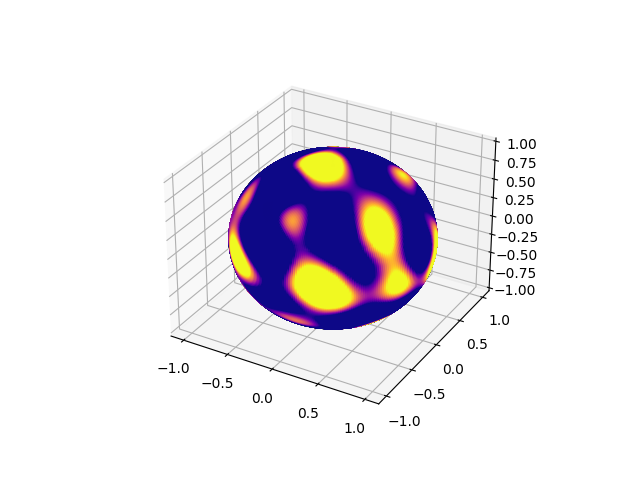

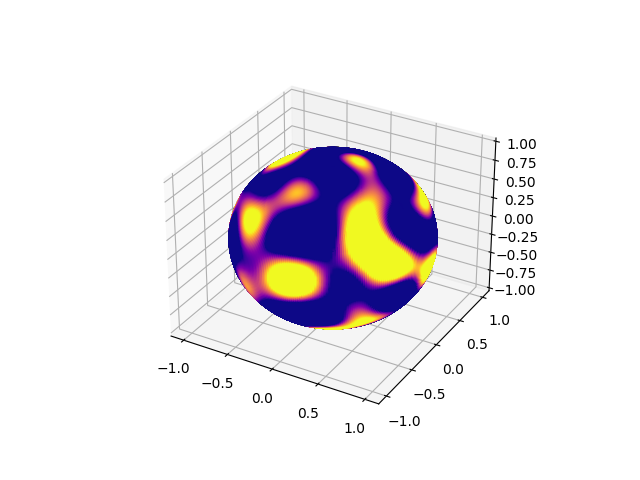

In [10]:
x, y, z = sphere_lattice()
points = torch.stack((x,y,z), dim=-1).reshape(-1, 3)
samples = sphere_sampler(points).reshape(x.shape[0], x.shape[1])
plot_sphere(x, y, z, samples)
plot_sphere(-x, -y, -z, samples)

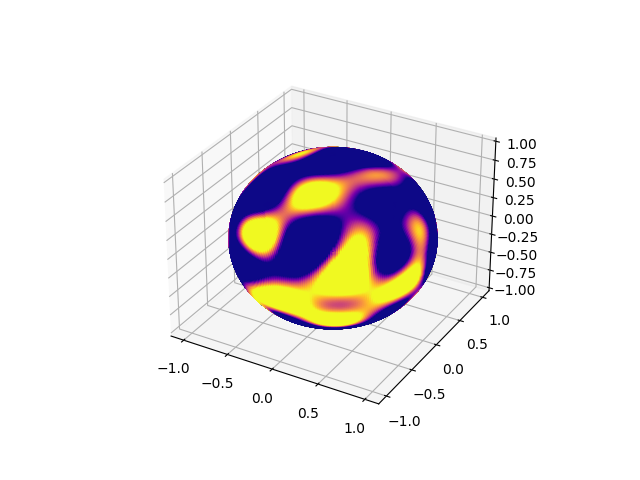

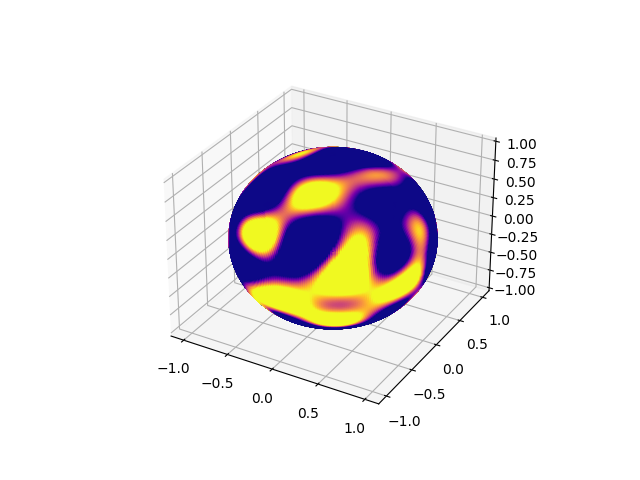

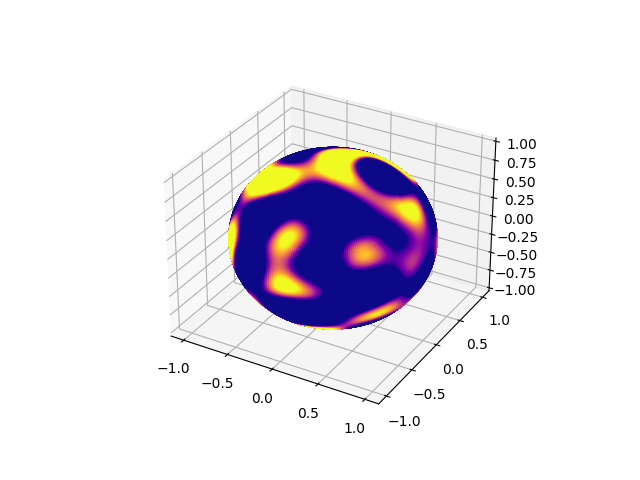

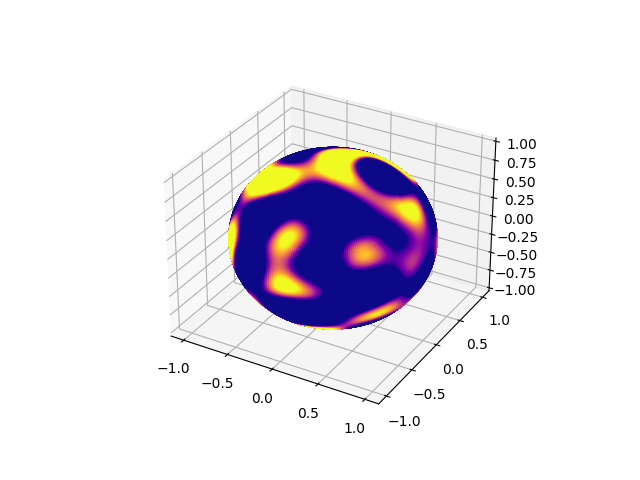

In [9]:
grassmanian = Grassmanian(3,1, order=10, average_order=10)
grassmanian_kernel = EigenbasisSumKernel(measure=measure, manifold=sphere)
grassmanian_sampler = RandomPhaseApproximation(kernel=grassmanian_kernel, phase_order=10)
samples = grassmanian_sampler(points).reshape(x.shape[0], x.shape[1])
plot_sphere(x, y, z, samples)
plt.show()
plot_sphere(-x,-y,-z,samples)
plt.show()